<a href="https://colab.research.google.com/github/atikhasan007/Machine-Learning/blob/main/update1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset**

In [1]:


import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdrifaturrahman33/levir-cd")

print("Path to dataset files:", path)



100%|██████████| 2.30G/2.30G [00:18<00:00, 136MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd/versions/1


In [2]:


import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class LEVIRCDDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir_b = os.path.join(images_dir, 'B')  # Pre-change
        self.images_dir_a = os.path.join(images_dir, 'A')  # Post-change
        self.masks_dir = os.path.join(images_dir, 'label')
        self.transform = transform

        # Ensure consistent ordering of files
        self.images_b = sorted(f for f in os.listdir(self.images_dir_b) if f.endswith(('.png', '.jpg', '.jpeg')))
        self.images_a = sorted(f for f in os.listdir(self.images_dir_a) if f.endswith(('.png', '.jpg', '.jpeg')))
        self.masks = sorted(f for f in os.listdir(self.masks_dir) if f.endswith(('.png', '.jpg', '.jpeg')))

    def __len__(self):
        return len(self.images_b)

    def __getitem__(self, idx):
        img_path_b = os.path.join(self.images_dir_b, self.images_b[idx])  # Pre-change
        img_path_a = os.path.join(self.images_dir_a, self.images_a[idx])  # Post-change
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        # Load images
        image_b = cv2.imread(img_path_b, cv2.IMREAD_COLOR)  # BGR
        image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB)  # RGB
        image_b = image_b.astype(np.float32) / 255.0  # Normalize to [0, 1]

        image_a = cv2.imread(img_path_a, cv2.IMREAD_COLOR)  # BGR
        image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB)  # RGB
        image_a = image_a.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        mask = mask.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Apply transformations consistently
        if self.transform:
            augmented = self.transform(image=image_b, image1=image_a, mask=mask)  # Pre-change first
            image_b = augmented['image']  # Pre-change
            image_a = augmented['image1']  # Post-change
            mask = augmented['mask']  # Mask

        # Convert mask to tensor and add channel dimension
        # Ensure mask is a tensor and normalize
        # if isinstance(mask, np.ndarray):  # If Albumentations outputs a NumPy array
        #     mask = torch.from_numpy(mask).float().unsqueeze(0) / 255.0
        # elif isinstance(mask, torch.Tensor):  # If Albumentations outputs a PyTorch tensor
        mask = mask.unsqueeze(0)

        return image_b, image_a, mask


# Albumentations transformations
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={'image1': 'image'})  # Specify additional target for post-change image

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={'image1': 'image'})  # Specify additional target for post-change image

# Datasets
LEVIR_train_dataset = LEVIRCDDataset(
    images_dir="/root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/train",
    transform=train_transform
)

LEVIR_val_dataset = LEVIRCDDataset(
    images_dir="/root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/val",
    transform=val_transform
)

LEVIR_test_dataset = LEVIRCDDataset(
    images_dir="/root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/test",
    transform=val_transform
)

# Dataloaders
LEVIR_train_loader = DataLoader(LEVIR_train_dataset, batch_size=16, shuffle=True)
LEVIR_val_loader = DataLoader(LEVIR_val_dataset, batch_size=16, shuffle=False)
LEVIR_test_loader = DataLoader(LEVIR_test_dataset, batch_size=16, shuffle=False)


print(f'Training Dataset Length: {len(LEVIR_train_dataset)}')
print(f'Validation Dataset Length: {len(LEVIR_val_dataset)}')
print(f'Testing Dataset Length: {len(LEVIR_test_dataset)}')




Training Dataset Length: 445
Validation Dataset Length: 64
Testing Dataset Length: 128


মtraining set-এ মোট 445 টা data sample আছে।
প্রতিটা sample হচ্ছে একটা tuple — (image_a, image_b, mask)।

In [3]:
# Display the length of the training dataset (which represents the number of samples)
print("Training Dataset Length (Shape):")
display(len(LEVIR_train_dataset))

# Display some info about the dataset structure
# Since it's a custom Dataset, we can't directly use .info() like a pandas DataFrame.
# We can, however, show the structure of a single item from the dataset.
print("\nInfo about a single item in the Training Dataset:")
# Get one item from the dataset
image_b, image_a, mask = LEVIR_train_dataset[0]

print("Shape of pre-change image (image_b):", image_b.shape)
print("Data type of pre-change image (image_b):", image_b.dtype)

print("Shape of post-change image (image_a):", image_a.shape)
print("Data type of post-change image (image_a):", image_a.dtype)

print("Shape of mask:", mask.shape)
print("Data type of mask:", mask.dtype)

Training Dataset Length (Shape):


445


Info about a single item in the Training Dataset:
Shape of pre-change image (image_b): torch.Size([3, 256, 256])
Data type of pre-change image (image_b): torch.float32
Shape of post-change image (image_a): torch.Size([3, 256, 256])
Data type of post-change image (image_a): torch.float32
Shape of mask: torch.Size([1, 256, 256])
Data type of mask: torch.float32


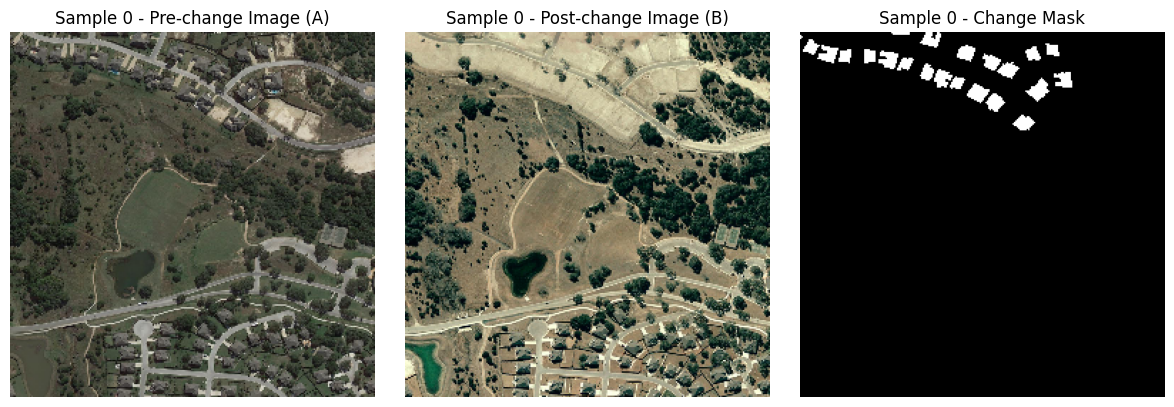

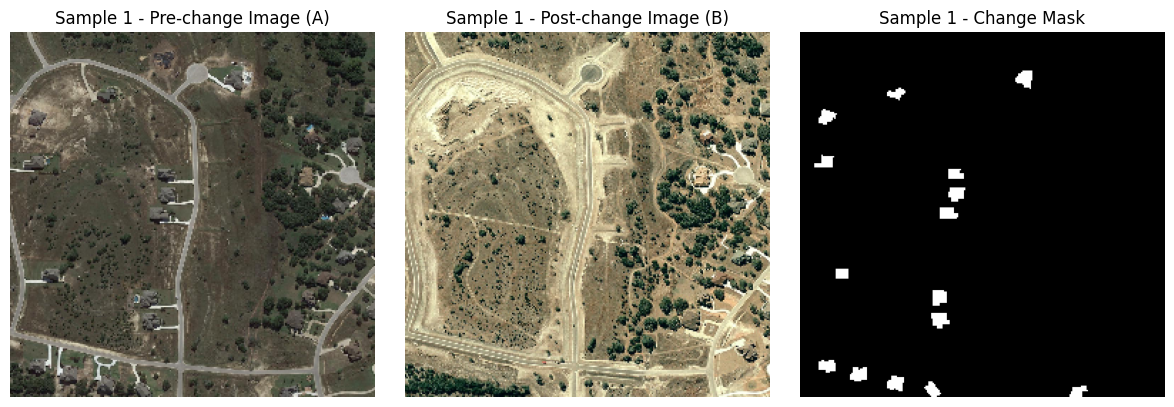

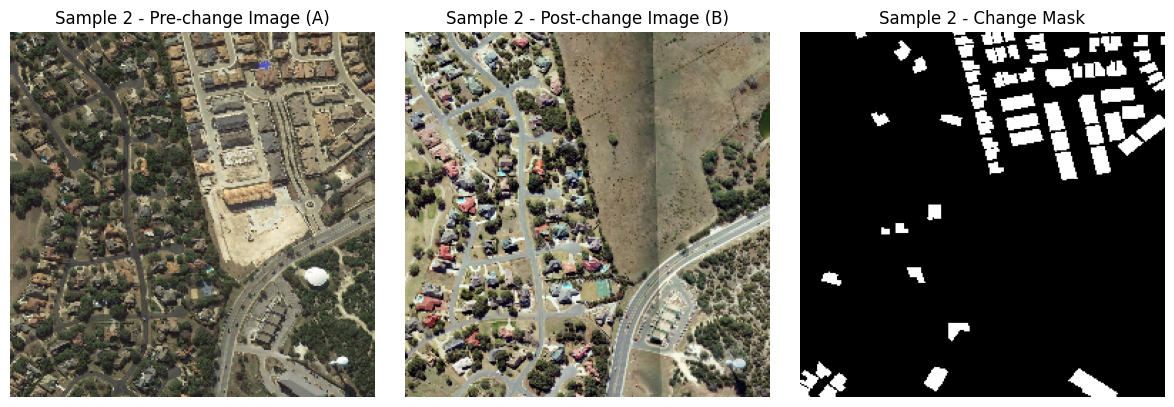

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to display a sample
def display_sample(image_b, image_a, mask, index):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Convert tensors to numpy arrays and transpose dimensions for plotting (C, H, W) -> (H, W, C)
    image_b_np = image_b.permute(1, 2, 0).numpy()
    image_a_np = image_a.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze(0).numpy() # Remove channel dimension for mask

    axes[0].imshow(image_b_np)
    axes[0].set_title(f'Sample {index} - Pre-change Image (A)')
    axes[0].axis('off')

    axes[1].imshow(image_a_np)
    axes[1].set_title(f'Sample {index} - Post-change Image (B)')
    axes[1].axis('off')

    # For the mask, use a colormap that clearly shows the change
    axes[2].imshow(mask_np, cmap='gray') # Assuming mask is grayscale (0 or 1)
    axes[2].set_title(f'Sample {index} - Change Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Display a few samples from the training dataset
num_samples_to_display = 3

for i in range(num_samples_to_display):
    image_b, image_a, mask = LEVIR_train_dataset[i]
    display_sample(image_b, image_a, mask, i)

In [5]:
import cv2
import numpy as np
import torch

'''Image=cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/train/22678915_15.png")
Mask=image=cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/train_labels/22678915_15.png")

print(f'Original mask shape:{Image.shape}')

print(f'Original mask shape:{Mask.shape}')'''

#print(np.unique(Mask))

image1, image2, mask = LEVIR_train_dataset[10]

print(f'Transformed Image shape:{image1.shape}')
print(f'Transformed Image shape:{image2.shape}')
print(f'Transformed mask shape:{mask.shape}')

print(torch.unique(mask))
print(torch.unique(image1))
print(torch.unique(image2))

print(torch.unique(mask).numel())

Transformed Image shape:torch.Size([3, 256, 256])
Transformed Image shape:torch.Size([3, 256, 256])
Transformed mask shape:torch.Size([1, 256, 256])
tensor([0., 1.])
tensor([0.0137, 0.0157, 0.0176,  ..., 0.9971, 0.9980, 1.0000])
tensor([0.0000e+00, 9.8039e-04, 1.9608e-03,  ..., 9.9804e-01, 9.9902e-01,
        1.0000e+00])
2


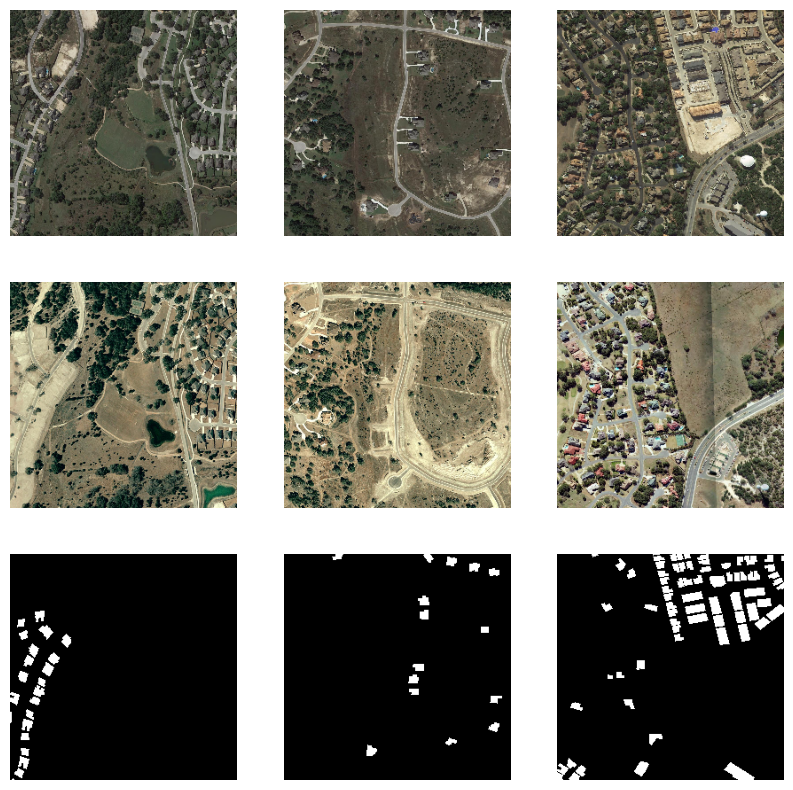

In [6]:

import matplotlib.pyplot as plt

# Set up the plot size and remove axes
plt.figure(figsize=(10, 10))  # Set the figure size to be larger

for i in range(3):
    image1, image2, mask = LEVIR_train_dataset[i]

    # Plot Image 1
    plt.subplot(3, 3, i+1)
    plt.imshow(image1.permute(1, 2, 0),cmap='gray')  # Convert tensor to HWC format
    plt.axis('off')  # Remove axes for a cleaner view

    # Plot Image 2
    plt.subplot(3, 3, 3+i+1)
    plt.imshow(image2.permute(1, 2, 0),cmap='gray')  # Convert tensor to HWC format
    plt.axis('off')  # Remove axes

    # Plot Mask
    plt.subplot(3, 3, 6+i+1)
    plt.imshow(mask.permute(1, 2, 0), cmap='gray')  # Display in grayscale
    plt.axis('off')  # Remove axes

plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic ConvBlock used in both encoder and decoder
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Encoder block: consists of two convolutions followed by max-pooling
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        p = self.pool(x)
        return x, p  # Return both the feature map and pooled result

# Decoder block: uses a transposed convolution (upsampling), followed by convolutions
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(in_channels + skip_channels, out_channels)  # Account for concatenation
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension
        x = self.conv1(x)
        x = self.conv2(x)
        return x


In [8]:
# The main combined Encoder Siamese U-Net architecture
class SiameseUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SiameseUNet, self).__init__()

        # Encoder blocks for image 1
        self.encoder1a = EncoderBlock(in_channels, 64)
        self.encoder2a = EncoderBlock(64, 128)
        self.encoder3a = EncoderBlock(128, 256)
        self.encoder4a = EncoderBlock(256, 512)

        # Encoder blocks for image 2
        self.encoder1b = EncoderBlock(in_channels, 64)
        self.encoder2b = EncoderBlock(64, 128)
        self.encoder3b = EncoderBlock(128, 256)
        self.encoder4b = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(1024, 1024)  # 512 + 512 from both encoders

        # Decoder block (shared between both images)
        self.decoder4 = DecoderBlock(1024, 512, 512)
        self.decoder3 = DecoderBlock(512, 256, 256)
        self.decoder2 = DecoderBlock(256, 128, 128)
        self.decoder1 = DecoderBlock(128, 64, 64)

        # Final convolution to output the segmentation map
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        # Encoder part for image 1
        e1a, p1a = self.encoder1a(x1)
        e2a, p2a = self.encoder2a(p1a)
        e3a, p3a = self.encoder3a(p2a)
        e4a, p4a = self.encoder4a(p3a)

        # Encoder part for image 2
        e1b, p1b = self.encoder1b(x2)
        e2b, p2b = self.encoder2b(p1b)
        e3b, p3b = self.encoder3b(p2b)
        e4b, p4b = self.encoder4b(p3b)

        # Concatenate the encoder outputs from both images (for each layer)
        concat_e4 = torch.cat([e4a, e4b], dim=1)  # Concatenate along the channel dimension
        concat_e3 = torch.cat([e3a, e3b], dim=1)
        concat_e2 = torch.cat([e2a, e2b], dim=1)
        concat_e1 = torch.cat([e1a, e1b], dim=1)

        # Bottleneck
        b = self.bottleneck(torch.cat([p4a, p4b], dim=1))

        # Decoder part (shared across both images)
        d4 = self.decoder4(b, concat_e4)
        d3 = self.decoder3(d4, concat_e3)
        d2 = self.decoder2(d3, concat_e2)
        d1 = self.decoder1(d2, concat_e1)

        # Final output
        out = self.sigmoid(self.final_conv(d1))
        return out


x1 = torch.randn(1, 3, 256, 256)  # Example image 1
x2 = torch.randn(1, 3, 256, 256)  # Example image 2

# Instantiate the Siamese U-Net model
siamese_unet = SiameseUNet(in_channels=3, out_channels=1)

# Get the output
output = siamese_unet(x1, x2)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 256, 256])


Train: ~70%
Validation: ~10%
Test: ~20%


In [9]:
print(f'Training Dataset Length (Shape): {len(LEVIR_train_dataset)}')
print(f'Validation Dataset Length (Shape): {len(LEVIR_val_dataset)}')
print(f'Testing Dataset Length (Shape): {len(LEVIR_test_dataset)}')

Training Dataset Length (Shape): 445
Validation Dataset Length (Shape): 64
Testing Dataset Length (Shape): 128


In [10]:
# Get one item from the training dataset to inspect its dimensions
image_b, image_a, mask = LEVIR_train_dataset[0]

print("Shape of pre-change image (image_b):", image_b.shape)
print("Shape of post-change image (image_a):", image_a.shape)
print("Shape of mask:", mask.shape)

Shape of pre-change image (image_b): torch.Size([3, 256, 256])
Shape of post-change image (image_a): torch.Size([3, 256, 256])
Shape of mask: torch.Size([1, 256, 256])


| Dataset    | Sample সংখ্যা  | মোট ফাইল সংখ্যা (image_a + image_b + mask) |
| ---------- | -------------- | ------------------------------------------ |
| Train      | 445            | 1335                                       |
| Validation | 64             | 192                                        |
| Test       | 128            | 384                                        |
| **মোট**    | **637 sample** | **1911 ফাইল**                              |


In [11]:
# Calculate the total number of files
total_files = (len(LEVIR_train_dataset) + len(LEVIR_val_dataset) + len(LEVIR_test_dataset)) * 3

print(f"Total number of files (image_a + image_b + mask) across all datasets: {total_files}")

Total number of files (image_a + image_b + mask) across all datasets: 1911


In [12]:
# Get the shape of a single image from the training dataset
# The shape is (Channels, Height, Width)
image_shape = LEVIR_train_dataset[0][0].shape

# Calculate the total number of pixels (Height * Width)
# We exclude the channel dimension for the pixel count
total_pixels_per_image = image_shape[1] * image_shape[2]

print(f"Shape of a single image: {image_shape}")
print(f"Total number of pixels in a single image: {total_pixels_per_image}")

Shape of a single image: torch.Size([3, 256, 256])
Total number of pixels in a single image: 65536


In [13]:
# Get the number of samples in each dataset split
num_train_samples = len(LEVIR_train_dataset)
num_val_samples = len(LEVIR_val_dataset)
num_test_samples = len(LEVIR_test_dataset)

# Get the total number of pixels per image (calculated in cell CmUJ6JHVHGw6)
# total_pixels_per_image = 65536

# Calculate the total number of pixels in all images (image_a and image_b) for each split
total_pixels_train = num_train_samples * 2 * total_pixels_per_image
total_pixels_val = num_val_samples * 2 * total_pixels_per_image
total_pixels_test = num_test_samples * 2 * total_pixels_per_image


# Calculate the grand total pixels across all splits
grand_total_pixels = total_pixels_train + total_pixels_val + total_pixels_test

print(f"Total pixels in training dataset images: {total_pixels_train}")
print(f"Total pixels in validation dataset images: {total_pixels_val}")
print(f"Total pixels in testing dataset images: {total_pixels_test}")
print(f"\n✅ Grand total pixels across all images (A and B) in the dataset: {grand_total_pixels}")

Total pixels in training dataset images: 58327040
Total pixels in validation dataset images: 8388608
Total pixels in testing dataset images: 16777216

✅ Grand total pixels across all images (A and B) in the dataset: 83492864


**Transfer Learning সহ Siamese U-Net training**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# ============================================================
# 1️⃣ Revised Siamese U-Net Model with Transfer Learning (Corrected Decoder)
# ============================================================

class SiameseUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, pretrained=True, freeze_encoder=False):
        super(SiameseUNet, self).__init__()

        # Load pretrained ResNet34 as the base encoder
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None)

        # Encoder layers (using ResNet's structure)
        self.conv1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu) # 64 channels, spatial ~H/2, W/2 (128x128 for 256x256 input)
        self.maxpool = resnet.maxpool # Initial maxpool: spatial ~H/4, W/4 (64x64)
        self.layer1 = resnet.layer1 # 64 features, spatial ~H/4, W/4 (64x64)
        self.layer2 = resnet.layer2 # 128 features, spatial ~H/8, W/8 (32x32)
        self.layer3 = resnet.layer3 # 256 features, spatial ~H/16, W/16 (16x16)
        self.layer4 = resnet.layer4 # 512 features, spatial ~H/32, W/32 (8x8)


        # Decoder Path with Upsampling and Skip Connections
        # We need to go from 512 channels (at 8x8) back to 1 channel (at 256x256)

        # Decoder block 4 (from layer4 output - 512@8x8)
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 8x8 -> 16x16 (256ch)
        self.decoder4 = self._conv_block(256 + 256, 256) # Concat with layer3 diff (256@16x16) -> 512ch -> 256ch @ 16x16

        # Decoder block 3 (from decoder4 output - 256@16x16)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 16x16 -> 32x32 (128ch)
        self.decoder3 = self._conv_block(128 + 128, 128) # Concat with layer2 diff (128@32x32) -> 256ch -> 128ch @ 32x32

        # Decoder block 2 (from decoder3 output - 128@32x32)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 32x32 -> 64x64 (64ch)
        self.decoder2 = self._conv_block(64 + 64, 64)   # Concat with layer1 diff (64@64x64) -> 128ch -> 64ch @ 64x64

        # Decoder block 1 (from decoder2 output - 64@64x64)
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2) # 64x64 -> 128x128 (64ch)
        # Concat with conv1 output (x1) which is 64@128x128
        self.decoder1 = self._conv_block(64 + 64, 64)   # Concat with conv1 diff (64@128x128) -> 128ch -> 64ch @ 128x128


        # Final upsampling to 256x256 and output layer
        self.upconv_final = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # 128x128 -> 256x256 (32ch)
        self.conv_out = nn.Conv2d(32, out_channels, kernel_size=1) # Final 1x1 convolution


        self.sigmoid = nn.Sigmoid()

        # Optionally freeze encoder parameters
        if freeze_encoder:
            for param in self.conv1.parameters():
                param.requires_grad = False
            for param in self.maxpool.parameters():
                param.requires_grad = False
            for param in self.layer1.parameters():
                param.requires_grad = False
            for param in self.layer2.parameters():
                param.requires_grad = False
            for param in self.layer3.parameters():
                param.requires_grad = False
            for param in self.layer4.parameters():
                param.requires_grad = False

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def _encode(self, x):
        # ResNet encoding path
        x1 = self.conv1(x)             # 64 channels, spatial H/2, W/2 (128x128)
        x_pool = self.maxpool(x1)      # spatial H/4, W/4 (64x64)

        x2 = self.layer1(x_pool)       # 64 channels, spatial H/4, W/4 (64x64)
        x3 = self.layer2(x2)           # 128 channels, spatial H/8, W/8 (32x32)
        x4 = self.layer3(x3)           # 256 channels, spatial H/16, W/16 (16x16)
        x5 = self.layer4(x4)           # 512 channels, spatial H/32, W/32 (8x8)

        # Return feature maps for skip connections and the bottleneck output
        # Note: x1 is before the first maxpool, others are after subsequent layers
        return [x1, x2, x3, x4, x5] # x1@128x128, x2@64x64, x3@32x32, x4@16x16, x5@8x8

    def forward(self, img1, img2):
        # Siamese encoder
        feats1 = self._encode(img1)
        feats2 = self._encode(img2)

        # Take absolute difference of features at each level
        # diff[0] is from x1 (128x128), diff[1] from x2 (64x64), ..., diff[4] from x5 (8x8)
        diff = [torch.abs(f1 - f2) for f1, f2 in zip(feats1, feats2)]

        # Decoder with skip connections (concatenation)
        # Start from the deepest feature difference (diff[4] from layer4 - 512@8x8)
        x = self.upconv4(diff[4]) # Upsample from 8x8 (512ch) to 16x16 (256ch)
        x = torch.cat([x, diff[3]], dim=1) # Concat with diff[3] (256@16x16) -> 512ch -> 256ch @ 16x16
        x = self.decoder4(x)

        x = self.upconv3(x) # Upsample from 16x16 (256ch) to 32x32 (128ch)
        x = torch.cat([x, diff[2]], dim=1) # Concat with diff[2] (128@32x32) -> 256ch -> 128ch @ 32x32
        x = self.decoder3(x)

        x = self.upconv2(x) # Upsample from 32x32 (128ch) to 64x64 (64ch)
        x = torch.cat([x, diff[1]], dim=1) # Concat with diff[1] (64@64x64) -> 128ch -> 64ch @ 64x64
        x = self.decoder2(x)

        x = self.upconv1(x) # Upsample from 64x64 (64ch) to 128x128 (64ch)
        # Concat with diff[0] which is 64@128x128
        x = torch.cat([x, diff[0]], dim=1) # Concat with diff[0] (64@128x128) -> 128ch -> 64ch @ 128x128
        x = self.decoder1(x)


        # Final upsampling to 256x256
        x = self.upconv_final(x) # Upsample from 128x128 (64ch) to 256x256 (32ch)
        out = self.conv_out(x) # 32ch -> 1ch @ 256x256

        return self.sigmoid(out)

# ============================================================
# 2️⃣ BCE + Dice Combined Loss
# ============================================================

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.smooth = 1e-6

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)

        # Dice Loss
        preds_flat = preds.view(-1)
        targets_flat = targets.view(-1)
        intersection = (preds_flat * targets_flat).sum()
        dice_coefficient = (2. * intersection + self.smooth) / (preds_flat.sum() + targets_flat.sum() + self.smooth)
        dice_loss = 1. - dice_coefficient

        return bce_loss + dice_loss


# ============================================================
# 3️⃣ Metrics Calculation
# ============================================================

def calculate_metrics(outputs, labels, threshold=0.5):
    predictions = (outputs > threshold).float()
    labels = labels.float()

    tp = torch.sum(predictions * labels)
    tn = torch.sum((1 - predictions) * (1 - labels))
    fp = torch.sum(predictions * (1 - labels))
    fn = torch.sum((1 - predictions) * labels)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
    iou = tp / (tp + fp + fn + 1e-6)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)

    return accuracy.item(), precision.item(), recall.item(), dice.item(), iou.item()

# ============================================================
# 4️⃣ Training Loop
# ============================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60, device='cuda'):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_iou_sum = train_acc_sum = train_precision_sum = train_recall_sum = train_dice_sum = 0
        train_samples = 0

        for inputs1, inputs2, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            # Move tensors to the selected device
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs1.size(0)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            train_acc_sum += acc * inputs1.size(0)
            train_precision_sum += precision * inputs1.size(0)
            train_recall_sum += recall * inputs1.size(0)
            train_dice_sum += dice * inputs1.size(0)
            train_iou_sum += iou * inputs1.size(0)
            train_samples += inputs1.size(0)

        epoch_train_loss = running_train_loss / train_samples
        epoch_train_iou = train_iou_sum / train_samples
        epoch_train_acc = train_acc_sum / train_samples
        epoch_train_precision = train_precision_sum / train_samples
        epoch_train_recall = train_recall_sum / train_samples
        epoch_train_dice = train_dice_sum / train_samples

        # =============== Validation ===============
        model.eval()
        running_val_loss = 0.0
        val_iou_sum = val_acc_sum = val_precision_sum = val_recall_sum = val_dice_sum = 0
        val_samples = 0

        with torch.no_grad():
            for inputs1, inputs2, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                # Move tensors to the selected device
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

                outputs = model(inputs1, inputs2)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs1.size(0)
                acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
                val_acc_sum += acc * inputs1.size(0)
                val_precision_sum += precision * inputs1.size(0)
                val_recall_sum += recall * inputs1.size(0)
                val_dice_sum += dice * inputs1.size(0)
                val_iou_sum += iou * inputs1.size(0)
                val_samples += inputs1.size(0)

        epoch_val_loss = running_val_loss / val_samples
        epoch_val_iou = val_iou_sum / val_samples
        epoch_val_acc = val_acc_sum / val_samples
        epoch_val_precision = val_precision_sum / val_samples
        epoch_val_recall = val_recall_sum / val_samples
        epoch_val_dice = val_dice_sum / val_samples


        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | '
              f'Train IoU: {epoch_train_iou:.4f}, Val IoU: {epoch_val_iou:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f} | '
              f'Train Precision: {epoch_train_precision:.4f}, Val Precision: {epoch_val_precision:.4f} | '
              f'Train Recall: {epoch_train_recall:.4f}, Val Recall: {epoch_val_recall:.4f} | '
              f'Train Dice: {epoch_train_dice:.4f}, Val Dice: {epoch_val_dice:.4f}')


    # Save final model
    torch.save(model.state_dict(), 'siamese_unet_transfer.pt')
    print("\n✅ Model saved as siamese_unet_transfer.pt")

# ============================================================
# 4️⃣ Initialize and Run Training
# ============================================================

if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Initialize model
    # Set freeze_encoder=True to freeze pretrained ResNet weights, False to fine-tune
    model = SiameseUNet(in_channels=3, out_channels=1,
                        pretrained=True, freeze_encoder=False).to(device)

    # Define Loss Function and Optimizer
    # criterion = nn.BCELoss() # Can use BCELoss alone
    criterion = BCEDiceLoss() # Or combined BCE and Dice Loss
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # ⚠️ Make sure LEVIR_train_loader and LEVIR_val_loader are defined by running cell mTdUDx4xDuvR
    # Train the model
    print("\nStarting model training...")
    train_model(model, LEVIR_train_loader, LEVIR_val_loader, criterion, optimizer,
                num_epochs=100, device=device)

    print("\nTraining complete. Model saved.")

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 174MB/s]



Starting model training...


Epoch 1/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Epoch 1/100 | Train Loss: 1.5244, Val Loss: 1.5188 | Train IoU: 0.1478, Val IoU: 0.2288 | Train Acc: 0.7921, Val Acc: 0.9096 | Train Precision: 0.1573, Val Precision: 0.2631 | Train Recall: 0.7050, Val Recall: 0.6474 | Train Dice: 0.2537, Val Dice: 0.3714


Epoch 2/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 2/100 | Train Loss: 1.4040, Val Loss: 1.3244 | Train IoU: 0.2747, Val IoU: 0.3448 | Train Acc: 0.9063, Val Acc: 0.9459 | Train Precision: 0.3010, Val Precision: 0.4115 | Train Recall: 0.7776, Val Recall: 0.6838 | Train Dice: 0.4288, Val Dice: 0.5124


Epoch 3/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Epoch 3/100 | Train Loss: 1.2907, Val Loss: 1.1759 | Train IoU: 0.3553, Val IoU: 0.3791 | Train Acc: 0.9346, Val Acc: 0.9424 | Train Precision: 0.3935, Val Precision: 0.4125 | Train Recall: 0.8028, Val Recall: 0.8261 | Train Dice: 0.5217, Val Dice: 0.5489


Epoch 4/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 4/100 | Train Loss: 1.1745, Val Loss: 1.1001 | Train IoU: 0.4270, Val IoU: 0.4327 | Train Acc: 0.9502, Val Acc: 0.9542 | Train Precision: 0.4737, Val Precision: 0.4778 | Train Recall: 0.8192, Val Recall: 0.8227 | Train Dice: 0.5968, Val Dice: 0.6036


Epoch 5/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 5/100 | Train Loss: 1.0736, Val Loss: 1.0293 | Train IoU: 0.4573, Val IoU: 0.5011 | Train Acc: 0.9562, Val Acc: 0.9694 | Train Precision: 0.5105, Val Precision: 0.6238 | Train Recall: 0.8314, Val Recall: 0.7181 | Train Dice: 0.6256, Val Dice: 0.6669


Epoch 6/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 6/100 | Train Loss: 0.9749, Val Loss: 0.9538 | Train IoU: 0.4953, Val IoU: 0.4929 | Train Acc: 0.9618, Val Acc: 0.9644 | Train Precision: 0.5516, Val Precision: 0.5675 | Train Recall: 0.8381, Val Recall: 0.7927 | Train Dice: 0.6608, Val Dice: 0.6593


Epoch 7/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 7/100 | Train Loss: 0.8850, Val Loss: 0.8598 | Train IoU: 0.5128, Val IoU: 0.5204 | Train Acc: 0.9643, Val Acc: 0.9693 | Train Precision: 0.5751, Val Precision: 0.6101 | Train Recall: 0.8380, Val Recall: 0.7801 | Train Dice: 0.6763, Val Dice: 0.6838


Epoch 8/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 8/100 | Train Loss: 0.8027, Val Loss: 0.7813 | Train IoU: 0.5345, Val IoU: 0.5385 | Train Acc: 0.9677, Val Acc: 0.9731 | Train Precision: 0.6052, Val Precision: 0.6709 | Train Recall: 0.8334, Val Recall: 0.7318 | Train Dice: 0.6953, Val Dice: 0.6991


Epoch 9/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


Epoch 9/100 | Train Loss: 0.7204, Val Loss: 0.7199 | Train IoU: 0.5478, Val IoU: 0.5230 | Train Acc: 0.9694, Val Acc: 0.9739 | Train Precision: 0.6193, Val Precision: 0.7114 | Train Recall: 0.8343, Val Recall: 0.6645 | Train Dice: 0.7061, Val Dice: 0.6850


Epoch 10/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Epoch 10/100 | Train Loss: 0.6499, Val Loss: 0.6578 | Train IoU: 0.5603, Val IoU: 0.5100 | Train Acc: 0.9706, Val Acc: 0.9725 | Train Precision: 0.6394, Val Precision: 0.6860 | Train Recall: 0.8241, Val Recall: 0.6668 | Train Dice: 0.7174, Val Dice: 0.6746


Epoch 11/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 11/100 | Train Loss: 0.5791, Val Loss: 0.5839 | Train IoU: 0.5838, Val IoU: 0.5524 | Train Acc: 0.9733, Val Acc: 0.9740 | Train Precision: 0.6702, Val Precision: 0.6775 | Train Recall: 0.8249, Val Recall: 0.7533 | Train Dice: 0.7369, Val Dice: 0.7115


Epoch 12/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


Epoch 12/100 | Train Loss: 0.5279, Val Loss: 0.5546 | Train IoU: 0.5912, Val IoU: 0.5429 | Train Acc: 0.9747, Val Acc: 0.9760 | Train Precision: 0.6877, Val Precision: 0.7452 | Train Recall: 0.8180, Val Recall: 0.6683 | Train Dice: 0.7425, Val Dice: 0.7027


Epoch 13/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Epoch 13/100 | Train Loss: 0.4886, Val Loss: 0.5148 | Train IoU: 0.5940, Val IoU: 0.5470 | Train Acc: 0.9753, Val Acc: 0.9768 | Train Precision: 0.6915, Val Precision: 0.7752 | Train Recall: 0.8189, Val Recall: 0.6499 | Train Dice: 0.7442, Val Dice: 0.7060


Epoch 14/100 [Val]: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 14/100 | Train Loss: 0.4475, Val Loss: 0.4817 | Train IoU: 0.6095, Val IoU: 0.5691 | Train Acc: 0.9766, Val Acc: 0.9760 | Train Precision: 0.7158, Val Precision: 0.7090 | Train Recall: 0.8130, Val Recall: 0.7435 | Train Dice: 0.7567, Val Dice: 0.7249


Epoch 15/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Epoch 15/100 | Train Loss: 0.4292, Val Loss: 0.5288 | Train IoU: 0.6075, Val IoU: 0.4891 | Train Acc: 0.9766, Val Acc: 0.9754 | Train Precision: 0.7167, Val Precision: 0.8234 | Train Recall: 0.8081, Val Recall: 0.5471 | Train Dice: 0.7555, Val Dice: 0.6550


Epoch 16/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 16/100 | Train Loss: 0.3982, Val Loss: 0.4505 | Train IoU: 0.6191, Val IoU: 0.5533 | Train Acc: 0.9777, Val Acc: 0.9772 | Train Precision: 0.7330, Val Precision: 0.7659 | Train Recall: 0.8056, Val Recall: 0.6671 | Train Dice: 0.7644, Val Dice: 0.7117


Epoch 17/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 17/100 | Train Loss: 0.3811, Val Loss: 0.4509 | Train IoU: 0.6251, Val IoU: 0.5411 | Train Acc: 0.9783, Val Acc: 0.9773 | Train Precision: 0.7368, Val Precision: 0.7956 | Train Recall: 0.8117, Val Recall: 0.6305 | Train Dice: 0.7686, Val Dice: 0.7015


Epoch 18/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 18/100 | Train Loss: 0.3618, Val Loss: 0.4118 | Train IoU: 0.6362, Val IoU: 0.5749 | Train Acc: 0.9791, Val Acc: 0.9781 | Train Precision: 0.7510, Val Precision: 0.7709 | Train Recall: 0.8115, Val Recall: 0.6939 | Train Dice: 0.7772, Val Dice: 0.7294


Epoch 19/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Epoch 19/100 | Train Loss: 0.3482, Val Loss: 0.4008 | Train IoU: 0.6420, Val IoU: 0.5804 | Train Acc: 0.9795, Val Acc: 0.9787 | Train Precision: 0.7583, Val Precision: 0.7870 | Train Recall: 0.8136, Val Recall: 0.6892 | Train Dice: 0.7817, Val Dice: 0.7337


Epoch 20/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 20/100 | Train Loss: 0.3318, Val Loss: 0.3852 | Train IoU: 0.6503, Val IoU: 0.5910 | Train Acc: 0.9802, Val Acc: 0.9772 | Train Precision: 0.7702, Val Precision: 0.7135 | Train Recall: 0.8110, Val Recall: 0.7764 | Train Dice: 0.7879, Val Dice: 0.7426


Epoch 21/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Epoch 21/100 | Train Loss: 0.3237, Val Loss: 0.3897 | Train IoU: 0.6542, Val IoU: 0.5876 | Train Acc: 0.9805, Val Acc: 0.9773 | Train Precision: 0.7741, Val Precision: 0.7293 | Train Recall: 0.8128, Val Recall: 0.7514 | Train Dice: 0.7906, Val Dice: 0.7397


Epoch 22/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 22/100 | Train Loss: 0.3157, Val Loss: 0.3807 | Train IoU: 0.6588, Val IoU: 0.5869 | Train Acc: 0.9807, Val Acc: 0.9784 | Train Precision: 0.7754, Val Precision: 0.7602 | Train Recall: 0.8188, Val Recall: 0.7227 | Train Dice: 0.7940, Val Dice: 0.7390


Epoch 23/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 23/100 | Train Loss: 0.3128, Val Loss: 0.3862 | Train IoU: 0.6581, Val IoU: 0.5732 | Train Acc: 0.9808, Val Acc: 0.9789 | Train Precision: 0.7737, Val Precision: 0.8159 | Train Recall: 0.8202, Val Recall: 0.6585 | Train Dice: 0.7933, Val Dice: 0.7276


Epoch 24/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 24/100 | Train Loss: 0.3023, Val Loss: 0.4185 | Train IoU: 0.6660, Val IoU: 0.5373 | Train Acc: 0.9814, Val Acc: 0.9782 | Train Precision: 0.7828, Val Precision: 0.8630 | Train Recall: 0.8208, Val Recall: 0.5875 | Train Dice: 0.7992, Val Dice: 0.6976


Epoch 25/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Epoch 25/100 | Train Loss: 0.2903, Val Loss: 0.3699 | Train IoU: 0.6757, Val IoU: 0.5873 | Train Acc: 0.9821, Val Acc: 0.9795 | Train Precision: 0.7902, Val Precision: 0.8153 | Train Recall: 0.8264, Val Recall: 0.6780 | Train Dice: 0.8062, Val Dice: 0.7391


Epoch 26/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Epoch 26/100 | Train Loss: 0.2866, Val Loss: 0.3537 | Train IoU: 0.6764, Val IoU: 0.6051 | Train Acc: 0.9822, Val Acc: 0.9798 | Train Precision: 0.7952, Val Precision: 0.7916 | Train Recall: 0.8207, Val Recall: 0.7214 | Train Dice: 0.8067, Val Dice: 0.7533


Epoch 27/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Epoch 27/100 | Train Loss: 0.2831, Val Loss: 0.3522 | Train IoU: 0.6782, Val IoU: 0.6045 | Train Acc: 0.9824, Val Acc: 0.9799 | Train Precision: 0.7939, Val Precision: 0.7935 | Train Recall: 0.8267, Val Recall: 0.7181 | Train Dice: 0.8079, Val Dice: 0.7528


Epoch 28/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 28/100 | Train Loss: 0.2873, Val Loss: 0.3441 | Train IoU: 0.6738, Val IoU: 0.6163 | Train Acc: 0.9823, Val Acc: 0.9784 | Train Precision: 0.7950, Val Precision: 0.7232 | Train Recall: 0.8204, Val Recall: 0.8075 | Train Dice: 0.8047, Val Dice: 0.7621


Epoch 29/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 29/100 | Train Loss: 0.2760, Val Loss: 0.3520 | Train IoU: 0.6833, Val IoU: 0.6044 | Train Acc: 0.9826, Val Acc: 0.9794 | Train Precision: 0.7986, Val Precision: 0.7781 | Train Recall: 0.8279, Val Recall: 0.7312 | Train Dice: 0.8116, Val Dice: 0.7525


Epoch 30/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Epoch 30/100 | Train Loss: 0.2746, Val Loss: 0.3685 | Train IoU: 0.6838, Val IoU: 0.5817 | Train Acc: 0.9827, Val Acc: 0.9794 | Train Precision: 0.7993, Val Precision: 0.8292 | Train Recall: 0.8298, Val Recall: 0.6620 | Train Dice: 0.8119, Val Dice: 0.7339


Epoch 31/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 31/100 | Train Loss: 0.2674, Val Loss: 0.3668 | Train IoU: 0.6910, Val IoU: 0.5826 | Train Acc: 0.9833, Val Acc: 0.9795 | Train Precision: 0.8061, Val Precision: 0.8245 | Train Recall: 0.8304, Val Recall: 0.6659 | Train Dice: 0.8170, Val Dice: 0.7350


Epoch 32/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 32/100 | Train Loss: 0.2620, Val Loss: 0.3735 | Train IoU: 0.6943, Val IoU: 0.5762 | Train Acc: 0.9833, Val Acc: 0.9794 | Train Precision: 0.8063, Val Precision: 0.8374 | Train Recall: 0.8353, Val Recall: 0.6493 | Train Dice: 0.8194, Val Dice: 0.7298


Epoch 33/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 33/100 | Train Loss: 0.2601, Val Loss: 0.3822 | Train IoU: 0.6949, Val IoU: 0.5665 | Train Acc: 0.9835, Val Acc: 0.9791 | Train Precision: 0.8101, Val Precision: 0.8464 | Train Recall: 0.8321, Val Recall: 0.6331 | Train Dice: 0.8198, Val Dice: 0.7218


Epoch 34/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Epoch 34/100 | Train Loss: 0.2547, Val Loss: 0.3683 | Train IoU: 0.7002, Val IoU: 0.5763 | Train Acc: 0.9838, Val Acc: 0.9798 | Train Precision: 0.8148, Val Precision: 0.8518 | Train Recall: 0.8343, Val Recall: 0.6408 | Train Dice: 0.8235, Val Dice: 0.7300


Epoch 35/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Epoch 35/100 | Train Loss: 0.2520, Val Loss: 0.3617 | Train IoU: 0.7021, Val IoU: 0.5858 | Train Acc: 0.9839, Val Acc: 0.9798 | Train Precision: 0.8162, Val Precision: 0.8327 | Train Recall: 0.8352, Val Recall: 0.6650 | Train Dice: 0.8248, Val Dice: 0.7378


Epoch 36/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 36/100 | Train Loss: 0.2452, Val Loss: 0.3381 | Train IoU: 0.7091, Val IoU: 0.6086 | Train Acc: 0.9842, Val Acc: 0.9806 | Train Precision: 0.8207, Val Precision: 0.8231 | Train Recall: 0.8397, Val Recall: 0.6998 | Train Dice: 0.8297, Val Dice: 0.7558


Epoch 37/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 37/100 | Train Loss: 0.2435, Val Loss: 0.3604 | Train IoU: 0.7103, Val IoU: 0.5850 | Train Acc: 0.9844, Val Acc: 0.9802 | Train Precision: 0.8192, Val Precision: 0.8615 | Train Recall: 0.8428, Val Recall: 0.6451 | Train Dice: 0.8304, Val Dice: 0.7368


Epoch 38/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 38/100 | Train Loss: 0.2406, Val Loss: 0.3225 | Train IoU: 0.7132, Val IoU: 0.6231 | Train Acc: 0.9846, Val Acc: 0.9809 | Train Precision: 0.8260, Val Precision: 0.8025 | Train Recall: 0.8398, Val Recall: 0.7364 | Train Dice: 0.8324, Val Dice: 0.7671


Epoch 39/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 39/100 | Train Loss: 0.2414, Val Loss: 0.3522 | Train IoU: 0.7115, Val IoU: 0.5930 | Train Acc: 0.9845, Val Acc: 0.9798 | Train Precision: 0.8225, Val Precision: 0.8160 | Train Recall: 0.8420, Val Recall: 0.6850 | Train Dice: 0.8313, Val Dice: 0.7436


Epoch 40/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 40/100 | Train Loss: 0.2393, Val Loss: 0.3768 | Train IoU: 0.7144, Val IoU: 0.5647 | Train Acc: 0.9846, Val Acc: 0.9795 | Train Precision: 0.8245, Val Precision: 0.8695 | Train Recall: 0.8431, Val Recall: 0.6171 | Train Dice: 0.8331, Val Dice: 0.7204


Epoch 41/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Epoch 41/100 | Train Loss: 0.2332, Val Loss: 0.3424 | Train IoU: 0.7196, Val IoU: 0.6009 | Train Acc: 0.9850, Val Acc: 0.9806 | Train Precision: 0.8287, Val Precision: 0.8427 | Train Recall: 0.8462, Val Recall: 0.6774 | Train Dice: 0.8368, Val Dice: 0.7495


Epoch 42/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Epoch 42/100 | Train Loss: 0.2331, Val Loss: 0.3207 | Train IoU: 0.7189, Val IoU: 0.6253 | Train Acc: 0.9850, Val Acc: 0.9808 | Train Precision: 0.8300, Val Precision: 0.7897 | Train Recall: 0.8434, Val Recall: 0.7506 | Train Dice: 0.8363, Val Dice: 0.7689


Epoch 43/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 43/100 | Train Loss: 0.2313, Val Loss: 0.3694 | Train IoU: 0.7208, Val IoU: 0.5758 | Train Acc: 0.9851, Val Acc: 0.9795 | Train Precision: 0.8290, Val Precision: 0.8404 | Train Recall: 0.8469, Val Recall: 0.6477 | Train Dice: 0.8375, Val Dice: 0.7292


Epoch 44/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 44/100 | Train Loss: 0.2303, Val Loss: 0.3373 | Train IoU: 0.7221, Val IoU: 0.6074 | Train Acc: 0.9853, Val Acc: 0.9807 | Train Precision: 0.8342, Val Precision: 0.8304 | Train Recall: 0.8441, Val Recall: 0.6933 | Train Dice: 0.8384, Val Dice: 0.7548


Epoch 45/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 45/100 | Train Loss: 0.2242, Val Loss: 0.3175 | Train IoU: 0.7285, Val IoU: 0.6291 | Train Acc: 0.9855, Val Acc: 0.9808 | Train Precision: 0.8345, Val Precision: 0.7903 | Train Recall: 0.8526, Val Recall: 0.7550 | Train Dice: 0.8428, Val Dice: 0.7716


Epoch 46/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 46/100 | Train Loss: 0.2289, Val Loss: 0.3616 | Train IoU: 0.7227, Val IoU: 0.5815 | Train Acc: 0.9852, Val Acc: 0.9802 | Train Precision: 0.8299, Val Precision: 0.8679 | Train Recall: 0.8501, Val Recall: 0.6379 | Train Dice: 0.8388, Val Dice: 0.7341


Epoch 47/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 47/100 | Train Loss: 0.2273, Val Loss: 0.3542 | Train IoU: 0.7241, Val IoU: 0.5880 | Train Acc: 0.9852, Val Acc: 0.9803 | Train Precision: 0.8339, Val Precision: 0.8558 | Train Recall: 0.8477, Val Recall: 0.6526 | Train Dice: 0.8398, Val Dice: 0.7394


Epoch 48/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Epoch 48/100 | Train Loss: 0.2204, Val Loss: 0.3745 | Train IoU: 0.7315, Val IoU: 0.5719 | Train Acc: 0.9857, Val Acc: 0.9795 | Train Precision: 0.8403, Val Precision: 0.8493 | Train Recall: 0.8499, Val Recall: 0.6365 | Train Dice: 0.8447, Val Dice: 0.7263


Epoch 49/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Epoch 49/100 | Train Loss: 0.2205, Val Loss: 0.3616 | Train IoU: 0.7312, Val IoU: 0.5817 | Train Acc: 0.9858, Val Acc: 0.9799 | Train Precision: 0.8385, Val Precision: 0.8462 | Train Recall: 0.8517, Val Recall: 0.6512 | Train Dice: 0.8446, Val Dice: 0.7344


Epoch 50/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 50/100 | Train Loss: 0.2185, Val Loss: 0.3400 | Train IoU: 0.7334, Val IoU: 0.6035 | Train Acc: 0.9859, Val Acc: 0.9803 | Train Precision: 0.8397, Val Precision: 0.8116 | Train Recall: 0.8537, Val Recall: 0.7020 | Train Dice: 0.8461, Val Dice: 0.7521


Epoch 51/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 51/100 | Train Loss: 0.2159, Val Loss: 0.3331 | Train IoU: 0.7361, Val IoU: 0.6120 | Train Acc: 0.9860, Val Acc: 0.9808 | Train Precision: 0.8425, Val Precision: 0.8224 | Train Recall: 0.8543, Val Recall: 0.7053 | Train Dice: 0.8479, Val Dice: 0.7585


Epoch 52/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 52/100 | Train Loss: 0.2165, Val Loss: 0.3603 | Train IoU: 0.7356, Val IoU: 0.5823 | Train Acc: 0.9860, Val Acc: 0.9801 | Train Precision: 0.8413, Val Precision: 0.8603 | Train Recall: 0.8550, Val Recall: 0.6424 | Train Dice: 0.8475, Val Dice: 0.7345


Epoch 53/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 53/100 | Train Loss: 0.2173, Val Loss: 0.3595 | Train IoU: 0.7345, Val IoU: 0.5850 | Train Acc: 0.9860, Val Acc: 0.9801 | Train Precision: 0.8391, Val Precision: 0.8543 | Train Recall: 0.8566, Val Recall: 0.6501 | Train Dice: 0.8467, Val Dice: 0.7367


Epoch 54/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 54/100 | Train Loss: 0.2101, Val Loss: 0.3378 | Train IoU: 0.7420, Val IoU: 0.6054 | Train Acc: 0.9864, Val Acc: 0.9808 | Train Precision: 0.8517, Val Precision: 0.8409 | Train Recall: 0.8528, Val Recall: 0.6835 | Train Dice: 0.8518, Val Dice: 0.7532


Epoch 55/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Epoch 55/100 | Train Loss: 0.2123, Val Loss: 0.3228 | Train IoU: 0.7392, Val IoU: 0.6212 | Train Acc: 0.9862, Val Acc: 0.9810 | Train Precision: 0.8444, Val Precision: 0.8112 | Train Recall: 0.8567, Val Recall: 0.7273 | Train Dice: 0.8500, Val Dice: 0.7656


Epoch 56/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 56/100 | Train Loss: 0.2122, Val Loss: 0.3627 | Train IoU: 0.7397, Val IoU: 0.5806 | Train Acc: 0.9863, Val Acc: 0.9802 | Train Precision: 0.8449, Val Precision: 0.8694 | Train Recall: 0.8563, Val Recall: 0.6359 | Train Dice: 0.8502, Val Dice: 0.7331


Epoch 57/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 57/100 | Train Loss: 0.2106, Val Loss: 0.3375 | Train IoU: 0.7412, Val IoU: 0.6082 | Train Acc: 0.9864, Val Acc: 0.9806 | Train Precision: 0.8459, Val Precision: 0.8193 | Train Recall: 0.8579, Val Recall: 0.7028 | Train Dice: 0.8512, Val Dice: 0.7553


Epoch 58/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Epoch 58/100 | Train Loss: 0.2109, Val Loss: 0.3551 | Train IoU: 0.7408, Val IoU: 0.5882 | Train Acc: 0.9863, Val Acc: 0.9805 | Train Precision: 0.8461, Val Precision: 0.8653 | Train Recall: 0.8565, Val Recall: 0.6478 | Train Dice: 0.8510, Val Dice: 0.7395


Epoch 59/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 59/100 | Train Loss: 0.2073, Val Loss: 0.3727 | Train IoU: 0.7445, Val IoU: 0.5721 | Train Acc: 0.9866, Val Acc: 0.9799 | Train Precision: 0.8478, Val Precision: 0.8796 | Train Recall: 0.8597, Val Recall: 0.6210 | Train Dice: 0.8534, Val Dice: 0.7261


Epoch 60/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Epoch 60/100 | Train Loss: 0.2050, Val Loss: 0.3774 | Train IoU: 0.7466, Val IoU: 0.5658 | Train Acc: 0.9867, Val Acc: 0.9797 | Train Precision: 0.8498, Val Precision: 0.8763 | Train Recall: 0.8607, Val Recall: 0.6152 | Train Dice: 0.8548, Val Dice: 0.7212


Epoch 61/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Epoch 61/100 | Train Loss: 0.2081, Val Loss: 0.3753 | Train IoU: 0.7432, Val IoU: 0.5701 | Train Acc: 0.9865, Val Acc: 0.9798 | Train Precision: 0.8488, Val Precision: 0.8724 | Train Recall: 0.8583, Val Recall: 0.6226 | Train Dice: 0.8526, Val Dice: 0.7244


Epoch 62/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 62/100 | Train Loss: 0.2061, Val Loss: 0.4267 | Train IoU: 0.7453, Val IoU: 0.5252 | Train Acc: 0.9866, Val Acc: 0.9781 | Train Precision: 0.8472, Val Precision: 0.8899 | Train Recall: 0.8616, Val Recall: 0.5615 | Train Dice: 0.8540, Val Dice: 0.6865


Epoch 63/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 63/100 | Train Loss: 0.2009, Val Loss: 0.3903 | Train IoU: 0.7517, Val IoU: 0.5596 | Train Acc: 0.9870, Val Acc: 0.9794 | Train Precision: 0.8538, Val Precision: 0.8791 | Train Recall: 0.8633, Val Recall: 0.6065 | Train Dice: 0.8581, Val Dice: 0.7157


Epoch 64/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 64/100 | Train Loss: 0.2027, Val Loss: 0.3403 | Train IoU: 0.7487, Val IoU: 0.6022 | Train Acc: 0.9869, Val Acc: 0.9809 | Train Precision: 0.8521, Val Precision: 0.8583 | Train Recall: 0.8612, Val Recall: 0.6686 | Train Dice: 0.8562, Val Dice: 0.7505


Epoch 65/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Epoch 65/100 | Train Loss: 0.1965, Val Loss: 0.3520 | Train IoU: 0.7564, Val IoU: 0.5928 | Train Acc: 0.9871, Val Acc: 0.9806 | Train Precision: 0.8551, Val Precision: 0.8680 | Train Recall: 0.8678, Val Recall: 0.6517 | Train Dice: 0.8612, Val Dice: 0.7425


Epoch 66/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 66/100 | Train Loss: 0.2007, Val Loss: 0.3204 | Train IoU: 0.7510, Val IoU: 0.6253 | Train Acc: 0.9870, Val Acc: 0.9812 | Train Precision: 0.8550, Val Precision: 0.8136 | Train Recall: 0.8613, Val Recall: 0.7303 | Train Dice: 0.8577, Val Dice: 0.7687


Epoch 67/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Epoch 67/100 | Train Loss: 0.1981, Val Loss: 0.3110 | Train IoU: 0.7538, Val IoU: 0.6347 | Train Acc: 0.9871, Val Acc: 0.9812 | Train Precision: 0.8549, Val Precision: 0.7917 | Train Recall: 0.8652, Val Recall: 0.7625 | Train Dice: 0.8595, Val Dice: 0.7760


Epoch 68/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Epoch 68/100 | Train Loss: 0.1982, Val Loss: 0.3713 | Train IoU: 0.7540, Val IoU: 0.5747 | Train Acc: 0.9871, Val Acc: 0.9799 | Train Precision: 0.8518, Val Precision: 0.8752 | Train Recall: 0.8689, Val Recall: 0.6257 | Train Dice: 0.8597, Val Dice: 0.7282


Epoch 69/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 69/100 | Train Loss: 0.1968, Val Loss: 0.3602 | Train IoU: 0.7554, Val IoU: 0.5863 | Train Acc: 0.9872, Val Acc: 0.9797 | Train Precision: 0.8592, Val Precision: 0.8247 | Train Recall: 0.8629, Val Recall: 0.6701 | Train Dice: 0.8605, Val Dice: 0.7380


Epoch 70/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Epoch 70/100 | Train Loss: 0.1946, Val Loss: 0.3300 | Train IoU: 0.7577, Val IoU: 0.6126 | Train Acc: 0.9872, Val Acc: 0.9812 | Train Precision: 0.8555, Val Precision: 0.8485 | Train Recall: 0.8693, Val Recall: 0.6867 | Train Dice: 0.8621, Val Dice: 0.7587


Epoch 71/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 71/100 | Train Loss: 0.1937, Val Loss: 0.3724 | Train IoU: 0.7585, Val IoU: 0.5767 | Train Acc: 0.9874, Val Acc: 0.9798 | Train Precision: 0.8575, Val Precision: 0.8566 | Train Recall: 0.8687, Val Recall: 0.6386 | Train Dice: 0.8625, Val Dice: 0.7300


Epoch 72/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 72/100 | Train Loss: 0.1965, Val Loss: 0.3653 | Train IoU: 0.7559, Val IoU: 0.5795 | Train Acc: 0.9872, Val Acc: 0.9801 | Train Precision: 0.8579, Val Precision: 0.8691 | Train Recall: 0.8650, Val Recall: 0.6349 | Train Dice: 0.8608, Val Dice: 0.7324


Epoch 73/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Epoch 73/100 | Train Loss: 0.1966, Val Loss: 0.3228 | Train IoU: 0.7550, Val IoU: 0.6233 | Train Acc: 0.9873, Val Acc: 0.9810 | Train Precision: 0.8566, Val Precision: 0.8093 | Train Recall: 0.8648, Val Recall: 0.7301 | Train Dice: 0.8603, Val Dice: 0.7670


Epoch 74/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 74/100 | Train Loss: 0.1930, Val Loss: 0.3291 | Train IoU: 0.7592, Val IoU: 0.6153 | Train Acc: 0.9875, Val Acc: 0.9810 | Train Precision: 0.8596, Val Precision: 0.8261 | Train Recall: 0.8673, Val Recall: 0.7070 | Train Dice: 0.8630, Val Dice: 0.7610


Epoch 75/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Epoch 75/100 | Train Loss: 0.1878, Val Loss: 0.3629 | Train IoU: 0.7655, Val IoU: 0.5821 | Train Acc: 0.9878, Val Acc: 0.9801 | Train Precision: 0.8623, Val Precision: 0.8517 | Train Recall: 0.8723, Val Recall: 0.6483 | Train Dice: 0.8671, Val Dice: 0.7343


Epoch 76/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 76/100 | Train Loss: 0.1868, Val Loss: 0.3553 | Train IoU: 0.7666, Val IoU: 0.5892 | Train Acc: 0.9878, Val Acc: 0.9806 | Train Precision: 0.8614, Val Precision: 0.8636 | Train Recall: 0.8747, Val Recall: 0.6497 | Train Dice: 0.8678, Val Dice: 0.7404


Epoch 77/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 77/100 | Train Loss: 0.1872, Val Loss: 0.3526 | Train IoU: 0.7659, Val IoU: 0.5928 | Train Acc: 0.9878, Val Acc: 0.9805 | Train Precision: 0.8634, Val Precision: 0.8571 | Train Recall: 0.8718, Val Recall: 0.6579 | Train Dice: 0.8673, Val Dice: 0.7428


Epoch 78/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 78/100 | Train Loss: 0.1922, Val Loss: 0.3579 | Train IoU: 0.7602, Val IoU: 0.5890 | Train Acc: 0.9876, Val Acc: 0.9805 | Train Precision: 0.8594, Val Precision: 0.8723 | Train Recall: 0.8688, Val Recall: 0.6440 | Train Dice: 0.8636, Val Dice: 0.7400


Epoch 79/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Epoch 79/100 | Train Loss: 0.1875, Val Loss: 0.3135 | Train IoU: 0.7651, Val IoU: 0.6308 | Train Acc: 0.9878, Val Acc: 0.9817 | Train Precision: 0.8632, Val Precision: 0.8215 | Train Recall: 0.8713, Val Recall: 0.7309 | Train Dice: 0.8668, Val Dice: 0.7730


Epoch 80/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Epoch 80/100 | Train Loss: 0.1855, Val Loss: 0.3122 | Train IoU: 0.7675, Val IoU: 0.6323 | Train Acc: 0.9880, Val Acc: 0.9819 | Train Precision: 0.8641, Val Precision: 0.8356 | Train Recall: 0.8732, Val Recall: 0.7215 | Train Dice: 0.8683, Val Dice: 0.7738


Epoch 81/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 81/100 | Train Loss: 0.1867, Val Loss: 0.3249 | Train IoU: 0.7663, Val IoU: 0.6243 | Train Acc: 0.9879, Val Acc: 0.9810 | Train Precision: 0.8612, Val Precision: 0.8089 | Train Recall: 0.8745, Val Recall: 0.7323 | Train Dice: 0.8675, Val Dice: 0.7680


Epoch 82/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 82/100 | Train Loss: 0.1860, Val Loss: 0.3881 | Train IoU: 0.7670, Val IoU: 0.5605 | Train Acc: 0.9879, Val Acc: 0.9794 | Train Precision: 0.8625, Val Precision: 0.8873 | Train Recall: 0.8741, Val Recall: 0.6029 | Train Dice: 0.8680, Val Dice: 0.7164


Epoch 83/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 83/100 | Train Loss: 0.1829, Val Loss: 0.3202 | Train IoU: 0.7701, Val IoU: 0.6231 | Train Acc: 0.9882, Val Acc: 0.9818 | Train Precision: 0.8689, Val Precision: 0.8577 | Train Recall: 0.8725, Val Recall: 0.6942 | Train Dice: 0.8700, Val Dice: 0.7667


Epoch 84/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Epoch 84/100 | Train Loss: 0.1831, Val Loss: 0.3383 | Train IoU: 0.7700, Val IoU: 0.6088 | Train Acc: 0.9881, Val Acc: 0.9810 | Train Precision: 0.8641, Val Precision: 0.8518 | Train Recall: 0.8766, Val Recall: 0.6803 | Train Dice: 0.8699, Val Dice: 0.7554


Epoch 85/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 85/100 | Train Loss: 0.1822, Val Loss: 0.3640 | Train IoU: 0.7712, Val IoU: 0.5837 | Train Acc: 0.9881, Val Acc: 0.9802 | Train Precision: 0.8676, Val Precision: 0.8656 | Train Recall: 0.8743, Val Recall: 0.6418 | Train Dice: 0.8707, Val Dice: 0.7355


Epoch 86/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 86/100 | Train Loss: 0.1831, Val Loss: 0.3221 | Train IoU: 0.7700, Val IoU: 0.6233 | Train Acc: 0.9881, Val Acc: 0.9815 | Train Precision: 0.8641, Val Precision: 0.8411 | Train Recall: 0.8761, Val Recall: 0.7055 | Train Dice: 0.8698, Val Dice: 0.7670


Epoch 87/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Epoch 87/100 | Train Loss: 0.1807, Val Loss: 0.3661 | Train IoU: 0.7730, Val IoU: 0.5822 | Train Acc: 0.9881, Val Acc: 0.9803 | Train Precision: 0.8678, Val Precision: 0.8816 | Train Recall: 0.8765, Val Recall: 0.6312 | Train Dice: 0.8719, Val Dice: 0.7344


Epoch 88/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 88/100 | Train Loss: 0.1773, Val Loss: 0.3244 | Train IoU: 0.7766, Val IoU: 0.6219 | Train Acc: 0.9885, Val Acc: 0.9815 | Train Precision: 0.8701, Val Precision: 0.8458 | Train Recall: 0.8787, Val Recall: 0.7010 | Train Dice: 0.8742, Val Dice: 0.7657


Epoch 89/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Epoch 89/100 | Train Loss: 0.1795, Val Loss: 0.3261 | Train IoU: 0.7745, Val IoU: 0.6196 | Train Acc: 0.9883, Val Acc: 0.9815 | Train Precision: 0.8695, Val Precision: 0.8451 | Train Recall: 0.8768, Val Recall: 0.6982 | Train Dice: 0.8728, Val Dice: 0.7641


Epoch 90/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 90/100 | Train Loss: 0.1766, Val Loss: 0.3589 | Train IoU: 0.7776, Val IoU: 0.5874 | Train Acc: 0.9885, Val Acc: 0.9803 | Train Precision: 0.8701, Val Precision: 0.8679 | Train Recall: 0.8802, Val Recall: 0.6443 | Train Dice: 0.8749, Val Dice: 0.7385


Epoch 91/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


Epoch 91/100 | Train Loss: 0.1819, Val Loss: 0.3145 | Train IoU: 0.7710, Val IoU: 0.6341 | Train Acc: 0.9882, Val Acc: 0.9812 | Train Precision: 0.8674, Val Precision: 0.8016 | Train Recall: 0.8758, Val Recall: 0.7517 | Train Dice: 0.8705, Val Dice: 0.7753


Epoch 92/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Epoch 92/100 | Train Loss: 0.1793, Val Loss: 0.3328 | Train IoU: 0.7745, Val IoU: 0.6122 | Train Acc: 0.9883, Val Acc: 0.9810 | Train Precision: 0.8680, Val Precision: 0.8351 | Train Recall: 0.8787, Val Recall: 0.6965 | Train Dice: 0.8728, Val Dice: 0.7586


Epoch 93/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 93/100 | Train Loss: 0.1778, Val Loss: 0.3752 | Train IoU: 0.7758, Val IoU: 0.5761 | Train Acc: 0.9884, Val Acc: 0.9799 | Train Precision: 0.8692, Val Precision: 0.8716 | Train Recall: 0.8790, Val Recall: 0.6286 | Train Dice: 0.8737, Val Dice: 0.7291


Epoch 94/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Epoch 94/100 | Train Loss: 0.1781, Val Loss: 0.3580 | Train IoU: 0.7757, Val IoU: 0.5882 | Train Acc: 0.9884, Val Acc: 0.9806 | Train Precision: 0.8685, Val Precision: 0.8749 | Train Recall: 0.8794, Val Recall: 0.6415 | Train Dice: 0.8736, Val Dice: 0.7394


Epoch 95/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 95/100 | Train Loss: 0.1797, Val Loss: 0.4298 | Train IoU: 0.7736, Val IoU: 0.5269 | Train Acc: 0.9883, Val Acc: 0.9782 | Train Precision: 0.8689, Val Precision: 0.8961 | Train Recall: 0.8766, Val Recall: 0.5610 | Train Dice: 0.8722, Val Dice: 0.6881


Epoch 96/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Epoch 96/100 | Train Loss: 0.1754, Val Loss: 0.3702 | Train IoU: 0.7784, Val IoU: 0.5793 | Train Acc: 0.9886, Val Acc: 0.9800 | Train Precision: 0.8741, Val Precision: 0.8647 | Train Recall: 0.8777, Val Recall: 0.6369 | Train Dice: 0.8753, Val Dice: 0.7321


Epoch 97/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 97/100 | Train Loss: 0.1726, Val Loss: 0.3299 | Train IoU: 0.7820, Val IoU: 0.6177 | Train Acc: 0.9887, Val Acc: 0.9811 | Train Precision: 0.8720, Val Precision: 0.8352 | Train Recall: 0.8837, Val Recall: 0.7029 | Train Dice: 0.8776, Val Dice: 0.7626


Epoch 98/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Epoch 98/100 | Train Loss: 0.1743, Val Loss: 0.3339 | Train IoU: 0.7796, Val IoU: 0.6127 | Train Acc: 0.9887, Val Acc: 0.9811 | Train Precision: 0.8729, Val Precision: 0.8479 | Train Recall: 0.8796, Val Recall: 0.6878 | Train Dice: 0.8760, Val Dice: 0.7587


Epoch 99/100 [Val]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 99/100 | Train Loss: 0.1705, Val Loss: 0.3536 | Train IoU: 0.7843, Val IoU: 0.5951 | Train Acc: 0.9889, Val Acc: 0.9805 | Train Precision: 0.8740, Val Precision: 0.8548 | Train Recall: 0.8846, Val Recall: 0.6617 | Train Dice: 0.8790, Val Dice: 0.7447


Epoch 100/100 [Val]: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

Epoch 100/100 | Train Loss: 0.1726, Val Loss: 0.3578 | Train IoU: 0.7820, Val IoU: 0.5898 | Train Acc: 0.9887, Val Acc: 0.9804 | Train Precision: 0.8737, Val Precision: 0.8627 | Train Recall: 0.8818, Val Recall: 0.6503 | Train Dice: 0.8776, Val Dice: 0.7405

✅ Model saved as siamese_unet_transfer.pt

Training complete. Model saved.


Evaluating on Test Set: 100%|██████████| 8/8 [00:14<00:00,  1.78s/it]



Confusion Matrix:
[[7918794   42583]
 [ 159129  268102]]

Classification Report:
              precision    recall  f1-score   support

   No Change       0.98      0.99      0.99   7961377
      Change       0.86      0.63      0.73    427231

    accuracy                           0.98   8388608
   macro avg       0.92      0.81      0.86   8388608
weighted avg       0.97      0.98      0.97   8388608



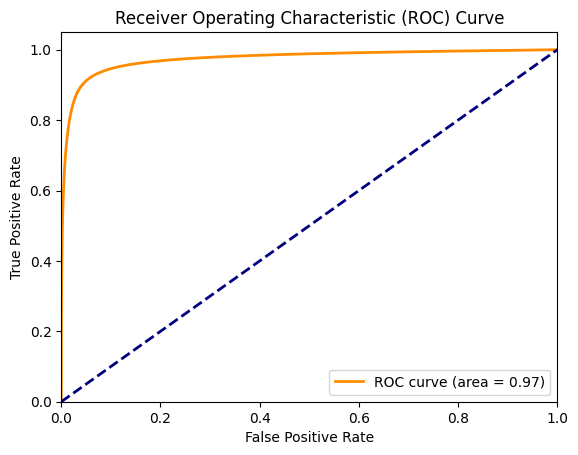

In [16]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming the model is already trained and saved as 'siamese_unet_transfer.pt'
# and the LEVIR_test_loader is available from previous cells

# Load the saved model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseUNet(in_channels=3, out_channels=1, pretrained=False).to(device) # Set pretrained=False as we are loading a trained model
model.load_state_dict(torch.load('siamese_unet_transfer.pt'))
model.eval() # Set the model to evaluation mode

all_labels = []
all_preds = []
all_probs = []

# Perform inference on the test dataset
with torch.no_grad():
    for inputs1, inputs2, labels in tqdm(LEVIR_test_loader, desc="Evaluating on Test Set"):
        inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

        outputs = model(inputs1, inputs2)
        probs = outputs.view(-1).cpu().numpy() # Flatten and move to CPU
        preds = (outputs > 0.5).float().view(-1).cpu().numpy() # Apply threshold, flatten, and move to CPU
        labels = labels.view(-1).cpu().numpy() # Flatten and move to CPU

        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs)

# Convert lists to numpy arrays
all_labels = np.array(all_labels).astype(int) # Ensure labels are integer (binary)
all_preds = np.array(all_preds).astype(int)   # Ensure predictions are integer (binary)
all_probs = np.array(all_probs)

# Calculate and print Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Calculate and print Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['No Change', 'Change'])) # Assuming 0 is no change, 1 is change

# Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

hybrid

In [23]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # conv1 input = upconv output channels + skip connection channels
        self.conv1 = ConvBlock(out_channels + skip_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        # If channel mismatch occurs due to concatenation, reduce skip channels using 1x1 conv
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# =========================================
# Hybrid Siamese UNet fixed
# =========================================
class HybridSiameseUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HybridSiameseUNet, self).__init__()

        # --- Encoders ---
        self.encoder1a = EncoderBlock(in_channels, 64)
        self.encoder2a = EncoderBlock(64, 128)
        self.encoder3a = EncoderBlock(128, 256)
        self.encoder4a = EncoderBlock(256, 512)

        self.encoder1b = EncoderBlock(in_channels, 64)
        self.encoder2b = EncoderBlock(64, 128)
        self.encoder3b = EncoderBlock(128, 256)
        self.encoder4b = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(1024, 1024)

        # --- Decoder ---
        self.decoder4 = DecoderBlock(1024, 1024, 512)  # skip = concat_e4 channels = 512+512=1024
        self.decoder3 = DecoderBlock(512, 512, 256)    # skip = concat_e3 channels = 256+256=512
        self.decoder2 = DecoderBlock(256, 256, 128)    # skip = concat_e2 channels = 128+128=256
        self.decoder1 = DecoderBlock(128, 128, 64)     # skip = concat_e1 channels = 64+64=128

        # Hybrid addition
        self.hybrid_conv1 = ConvBlock(64, 32)
        self.hybrid_conv2 = ConvBlock(32, 16)

        # Final output
        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        # --- Encoder ---
        e1a, p1a = self.encoder1a(x1)
        e2a, p2a = self.encoder2a(p1a)
        e3a, p3a = self.encoder3a(p2a)
        e4a, p4a = self.encoder4a(p3a)

        e1b, p1b = self.encoder1b(x2)
        e2b, p2b = self.encoder2b(p1b)
        e3b, p3b = self.encoder3b(p2b)
        e4b, p4b = self.encoder4b(p3b)

        # --- Concatenate skip connections ---
        concat_e4 = torch.cat([e4a, e4b], dim=1)  # 512+512=1024
        concat_e3 = torch.cat([e3a, e3b], dim=1)  # 256+256=512
        concat_e2 = torch.cat([e2a, e2b], dim=1)  # 128+128=256
        concat_e1 = torch.cat([e1a, e1b], dim=1)  # 64+64=128

        # --- Bottleneck ---
        b = self.bottleneck(torch.cat([p4a, p4b], dim=1))  # 512+512=1024

        # --- Decoder ---
        d4 = self.decoder4(b, concat_e4)
        d3 = self.decoder3(d4, concat_e3)
        d2 = self.decoder2(d3, concat_e2)
        d1 = self.decoder1(d2, concat_e1)

        # --- Hybrid ---
        h = self.hybrid_conv1(d1)
        h = self.hybrid_conv2(h)

        out = self.sigmoid(self.final_conv(h))
        return out

# Example
x1 = torch.randn(1,3,256,256)
x2 = torch.randn(1,3,256,256)
model = HybridSiameseUNet(3,1)
output = model(x1,x2)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 256, 256])


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# =========================================
# Metrics calculation
# =========================================
def calculate_metrics(outputs, labels, threshold=0.5):
    predictions = (outputs > threshold).float()
    labels = labels.float()

    tp = torch.sum(predictions * labels)
    tn = torch.sum((1 - predictions) * (1 - labels))
    fp = torch.sum(predictions * (1 - labels))
    fn = torch.sum((1 - predictions) * labels)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
    iou = tp / (tp + fp + fn + 1e-6)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)

    return accuracy.item(), precision.item(), recall.item(), dice.item(), iou.item(), predictions

# =========================================
# Training Loop with history
# =========================================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60, device='cuda'):
    model.to(device)
    history = {
        'train_loss':[], 'val_loss':[],
        'train_iou':[], 'val_iou':[],
        'train_acc':[], 'val_acc':[],
        'train_precision':[], 'val_precision':[],
        'train_recall':[], 'val_recall':[],
        'train_dice':[], 'val_dice':[]
    }

    all_val_labels = []
    all_val_preds = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_iou_sum = train_acc_sum = train_precision_sum = train_recall_sum = train_dice_sum = 0
        train_samples = 0

        for inputs1, inputs2, labels in train_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs1.size(0)
            acc, precision, recall, dice, iou, _ = calculate_metrics(outputs, labels)
            train_acc_sum += acc * inputs1.size(0)
            train_precision_sum += precision * inputs1.size(0)
            train_recall_sum += recall * inputs1.size(0)
            train_dice_sum += dice * inputs1.size(0)
            train_iou_sum += iou * inputs1.size(0)
            train_samples += inputs1.size(0)

        epoch_train_loss = running_train_loss / train_samples
        epoch_train_iou = train_iou_sum / train_samples
        epoch_train_acc = train_acc_sum / train_samples
        epoch_train_precision = train_precision_sum / train_samples
        epoch_train_recall = train_recall_sum / train_samples
        epoch_train_dice = train_dice_sum / train_samples

        # Validation
        model.eval()
        running_val_loss = 0.0
        val_iou_sum = val_acc_sum = val_precision_sum = val_recall_sum = val_dice_sum = 0
        val_samples = 0
        all_val_labels.clear()
        all_val_preds.clear()

        with torch.no_grad():
            for inputs1, inputs2, labels in val_loader:
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs1.size(0)

                acc, precision, recall, dice, iou, preds = calculate_metrics(outputs, labels)
                val_acc_sum += acc * inputs1.size(0)
                val_precision_sum += precision * inputs1.size(0)
                val_recall_sum += recall * inputs1.size(0)
                val_dice_sum += dice * inputs1.size(0)
                val_iou_sum += iou * inputs1.size(0)
                val_samples += inputs1.size(0)

                all_val_labels.append(labels.cpu().numpy().flatten())
                all_val_preds.append(preds.cpu().numpy().flatten())

        epoch_val_loss = running_val_loss / val_samples
        epoch_val_iou = val_iou_sum / val_samples
        epoch_val_acc = val_acc_sum / val_samples
        epoch_val_precision = val_precision_sum / val_samples
        epoch_val_recall = val_recall_sum / val_samples
        epoch_val_dice = val_dice_sum / val_samples

        # Save metrics history for plotting
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_iou'].append(epoch_train_iou)
        history['val_iou'].append(epoch_val_iou)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        history['train_precision'].append(epoch_train_precision)
        history['val_precision'].append(epoch_val_precision)
        history['train_recall'].append(epoch_train_recall)
        history['val_recall'].append(epoch_val_recall)
        history['train_dice'].append(epoch_train_dice)
        history['val_dice'].append(epoch_val_dice)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | '
              f'Train IoU: {epoch_train_iou:.4f}, Val IoU: {epoch_val_iou:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f} | '
              f'Train Precision: {epoch_train_precision:.4f}, Val Precision: {epoch_val_precision:.4f} | '
              f'Train Recall: {epoch_train_recall:.4f}, Val Recall: {epoch_val_recall:.4f} | '
              f'Train Dice: {epoch_train_dice:.4f}, Val Dice: {epoch_val_dice:.4f}')

    # Save model
    torch.save(model.state_dict(), 'hybrid_siamese_unet.pt')

    # Confusion Matrix & Classification Report
    all_val_labels = np.concatenate(all_val_labels)
    all_val_preds = np.concatenate(all_val_preds)
    cm = confusion_matrix(all_val_labels, all_val_preds)
    cr = classification_report(all_val_labels, all_val_preds, digits=4)

    print("\n=== Confusion Matrix ===\n", cm)
    print("\n=== Classification Report ===\n", cr)

    # Plot curves
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title("IoU Curve")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()
    plt.show()

    return model, history

# =========================================
# Usage
# =========================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HybridSiameseUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

trained_model, history = train_model(model, LEVIR_train_loader, LEVIR_val_loader, criterion, optimizer, num_epochs=100, device=device)


Epoch 1/100 | Train Loss: 0.5360, Val Loss: 0.5282 | Train IoU: 0.1539, Val IoU: 0.0009 | Train Acc: 0.8433, Val Acc: 0.9580 | Train Precision: 0.1745, Val Precision: 0.2308 | Train Recall: 0.5604, Val Recall: 0.0009 | Train Dice: 0.2605, Val Dice: 0.0018
Epoch 2/100 | Train Loss: 0.4490, Val Loss: 0.4075 | Train IoU: 0.3516, Val IoU: 0.1660 | Train Acc: 0.9448, Val Acc: 0.9599 | Train Precision: 0.4391, Val Precision: 0.6350 | Train Recall: 0.6509, Val Recall: 0.1987 | Train Dice: 0.5163, Val Dice: 0.2764
Epoch 3/100 | Train Loss: 0.4104, Val Loss: 0.4077 | Train IoU: 0.4384, Val IoU: 0.4089 | Train Acc: 0.9620, Val Acc: 0.9669 | Train Precision: 0.5764, Val Precision: 0.6367 | Train Recall: 0.6536, Val Recall: 0.5513 | Train Dice: 0.6078, Val Dice: 0.5747
Epoch 4/100 | Train Loss: 0.3927, Val Loss: 0.3919 | Train IoU: 0.4777, Val IoU: 0.5056 | Train Acc: 0.9668, Val Acc: 0.9699 | Train Precision: 0.6285, Val Precision: 0.6219 | Train Recall: 0.6731, Val Recall: 0.7383 | Train Dice: 0